<a href="https://colab.research.google.com/github/Lawrence-Krukrubo/fraud_analyst_assignment/blob/main/05_prescriptive_analytics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# First let's mount Google Drive so we can navigate the folders as needed
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


**Let's import some much needed libraries...**

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import random
import xlrd
print('done!')

done!


In [3]:
# Let's import some Deeplearning modules

import tensorflow as tf
from tensorflow import keras
import tempfile

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
print('done!')

done!


In [4]:
# Let's get all the colors available in matplotlib
other_colors = []
darker_colors = []
for name, hex in mpl.colors.cnames.items():
    if 'dark' in name:
        darker_colors.append(name)
    else:
        other_colors.append(name)

# Let's finally save the various plot styles in matplotlib
styles = plt.style.available

print(f'darker-colors has {len(darker_colors)},\nother-colors has {len(other_colors)} colors\nplotting styles are {len(styles)}')

darker-colors has 19,
other-colors has 129 colors
plotting styles are 26


In [5]:
# set more matplotlib defaults
def set_rcParams():
    mpl.rcParams['axes.labelsize'] = 12
    mpl.rcParams['xtick.labelsize'] = 10
    mpl.rcParams['ytick.labelsize'] = 10
    mpl.rcParams['text.color'] = 'k'
    mpl.rc('lines', linewidth=4, linestyle='-.')
    print('rcParams set!')

# Set the plots design to xkcd
# plt.xkcd()  # For xkcd style plots
#plt.rcdefaults()  # to stop xkcd plots

# fontdict for plot titles
fontDict1 = {'fontfamily': 'fantasy',
             'fontsize': 'x-large',
             'fontstyle': 'italic',
             'fontweight': 'heavy',
             'ha': 'center',
             'color': 'darkred',
             'va': 'baseline'}

# fontdict for plot labels
fontDict2 = {'fontfamily': 'serif',
             'fontsize': 'large',
             'fontstyle': 'oblique',
             'fontweight': 'semibold',
             'ha': 'center',
             'color': 'black',
             'va': 'baseline'}

set_rcParams()

rcParams set!


**Let's change our Directory to the Fraud directory containing our data**

In [6]:
FRAUD_DIR = '/content/gdrive/MyDrive/Colab_Notebooks/fraud_analyst_assignment'
os.chdir(FRAUD_DIR)
print(f'Current Dir: {os.getcwd()}')

Current Dir: /content/gdrive/MyDrive/Colab_Notebooks/fraud_analyst_assignment


In [7]:
# Let's see some of the contents of the CWD
os.listdir()[:10]

['Fraud_sample_data.xlsx',
 '.ipynb_checkpoints',
 '01_intro_to_fraud_analysis.ipynb',
 'fraud_analysis.ipynb',
 'july_df.csv',
 'data_dict.csv',
 'june_df.csv',
 'top_five_clusters.csv',
 'mi_combined.csv',
 'top_fraud_cluster.csv']

### 1. Loading previous data from Diagnostic stage..

In [8]:
# First, we load the data dictionary...

pd.set_option('max_colwidth', None)
data_dict  = pd.read_csv('data_dict.csv')
data_dict

,Field name,Field description
0,merchant_id,Randomly generated identifier to represent a merchant
1,merchant_industry,Industry in which the merchant operates
2,merchant_category,Business category of the merchant
3,merchant_country,The country in which the merchant is based
4,currency,The local currency the transcation was processed in
5,transaction_week_start_date,Week in which the transaction occured
6,channel,The payment method for the transaction
7,transaction_count,The number of transactions for the day
8,transaction_volume_usd,The total value of the transactions converted to USD
9,fraud_count,The number of transactions which were reported as fraudulent for the day


In [9]:
# Next, we load combined_df, the original unprocessed June & July data.

combined_df = pd.read_csv('combined_df.csv')
print(f'shape of combined_df; {combined_df.shape}\n')
combined_df.head(3)

shape of combined_df; (17418, 13)



,merchant_id,merchant_industry,merchant_category,merchant_country,currency,transaction_week_start_date,channel,transaction_count,transaction_volume_usd,fraud_count,fraud_volume_usd,otp_fraud,otp_all_transactions
0,1,GOODS-PHYSICAL,e-Commerce,Nigeria,NGN,2021-06-07,card,5,231.590551,0,0.0,0,5
1,5,SERVICES-LEGAL,Other,Nigeria,NGN,2021-06-07,card,2,210.203412,0,0.0,0,2
2,9,TRAVEL,Travel & Hospitality,Nigeria,NGN,2021-06-07,card,4,223.097113,0,0.0,0,1


# Prescriptive EDA (PA2): 

**Prescriptive Analytics:**<br>
Prescriptive analytics attempt to quantify the effect of future decisions 
in order to advise on possible outcomes before the decisions are 
actually made.

These analytics are all about providing advice

These analytics go beyond descriptive and predictive analytics by 
recommending one or more possible courses of action. 

In this notebook, we will attempt to build a Deep-Learning Model that can learn intricate patterns in the data, so as to properly classify future transactions as either `fraud` or `not-fraud`, with an associated probability score that can tell us how confident the model prediction is on each attempt.

We shall combine this model with other behavioral insights to help fight fraudulent transactions as quickly as they occur.

### 1. Let's see the split of fraud and non-fraud cases in the data

In [10]:
# first let's add a column of True/False if fraud is reported or not.

combined_df['is_fraud'] = np.where(combined_df['fraud_count'] > 0, True, False)
combined_df.head(3)

,merchant_id,merchant_industry,merchant_category,merchant_country,currency,transaction_week_start_date,channel,transaction_count,transaction_volume_usd,fraud_count,fraud_volume_usd,otp_fraud,otp_all_transactions,is_fraud
0,1,GOODS-PHYSICAL,e-Commerce,Nigeria,NGN,2021-06-07,card,5,231.590551,0,0.0,0,5,False
1,5,SERVICES-LEGAL,Other,Nigeria,NGN,2021-06-07,card,2,210.203412,0,0.0,0,2,False
2,9,TRAVEL,Travel & Hospitality,Nigeria,NGN,2021-06-07,card,4,223.097113,0,0.0,0,1,False


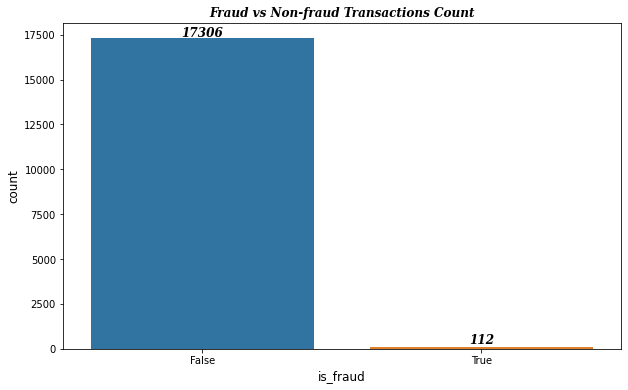

In [11]:
size = (10, 6)
plt.figure(figsize=size)
sns.countplot(x='is_fraud', data=combined_df), 
plt.title('Fraud vs Non-fraud Transactions Count', fontdict=fontDict2)
height1 = len(combined_df.is_fraud)-sum(combined_df.is_fraud)
height2 = sum(combined_df.is_fraud)
plt.text(0, height1+100, str(height1), fontdict=fontDict2)
plt.text(1, height2+200, str(height2), fontdict=fontDict2)

plt.show()

**We have a grossly imbalanced dataset**

Let's load the earlier preprocessed data set from Diagnostic Analytics stage

In [12]:
processed_df = pd.read_csv('processed_mi_combined.csv')
print('shape is {}'.format(processed_df.shape))
processed_df.head(3)

shape is (17418, 8)


,merchant_category,transaction_volume_usd,otp_fraud,merchant_industry,transaction_week_start_date,fraud_count,centroid,pt2centroid
0,0.0,0.823529,0.0,0.000000,0.0,0.0,20,0.190176
1,0.1,0.823529,0.0,0.016129,0.0,0.0,20,0.179691
2,0.2,0.823529,0.0,0.032258,0.0,0.0,20,0.178412


Let's see the numerical distribution, so we know how to normalize the centroid column

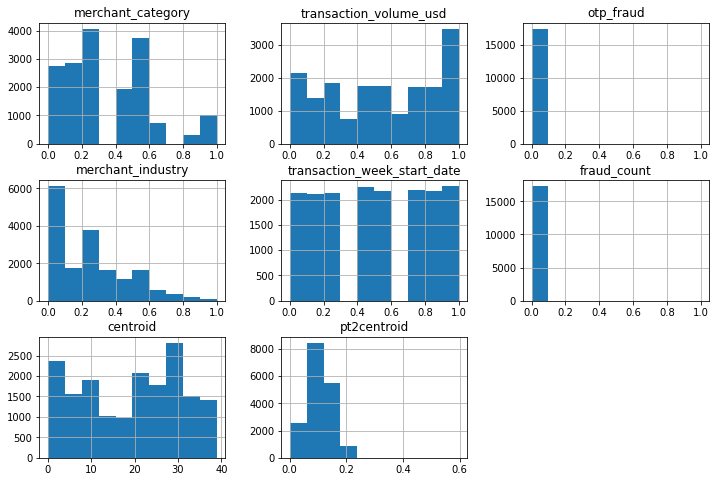

In [13]:
processed_df.hist(figsize=(12,8))
plt.show()

Let's use min-ma to normalize the `centroid` column

In [14]:
def minMaxScaler(numArr):
  minx = np.min(numArr)
  maxx = np.max(numArr)
  numArr = (numArr - minx) / (maxx - minx)
  return numArr

In [15]:
processed_df.centroid = minMaxScaler(processed_df.centroid)

In [16]:
# check for missing values
processed_df.isna().any().sum()

0

**Choosing and creating the target variable**

Since we want to predict if a transaction is fraud or not using the `fraud_count` column for each observation. Let's convert it to a binary class of 1 and 0 for True and False if it's fraud or not.

In [17]:
# let's make a target column
processed_df['target'] = combined_df.is_fraud

# next, let's drop the fraud_count variable and the is_fraud variable from combined_df
processed_df.drop(columns=['fraud_count'], inplace=True)
combined_df.drop(columns=['is_fraud'], inplace=True)

processed_df.head(3)

,merchant_category,transaction_volume_usd,otp_fraud,merchant_industry,transaction_week_start_date,centroid,pt2centroid,target
0,0.0,0.823529,0.0,0.000000,0.0,0.512821,0.190176,False
1,0.1,0.823529,0.0,0.016129,0.0,0.512821,0.179691,False
2,0.2,0.823529,0.0,0.032258,0.0,0.512821,0.178412,False


In [18]:
# let's make True or Flase, 0 or 1
processed_df['target'] = processed_df['target'].astype('int')
processed_df.head(3)

,merchant_category,transaction_volume_usd,otp_fraud,merchant_industry,transaction_week_start_date,centroid,pt2centroid,target
0,0.0,0.823529,0.0,0.000000,0.0,0.512821,0.190176,0
1,0.1,0.823529,0.0,0.016129,0.0,0.512821,0.179691,0
2,0.2,0.823529,0.0,0.032258,0.0,0.512821,0.178412,0


In [19]:
# check for missing values
processed_df.isna().any().sum()

0

In [20]:
# let's check the column deletion here
combined_df.head(3)

,merchant_id,merchant_industry,merchant_category,merchant_country,currency,transaction_week_start_date,channel,transaction_count,transaction_volume_usd,fraud_count,fraud_volume_usd,otp_fraud,otp_all_transactions
0,1,GOODS-PHYSICAL,e-Commerce,Nigeria,NGN,2021-06-07,card,5,231.590551,0,0.0,0,5
1,5,SERVICES-LEGAL,Other,Nigeria,NGN,2021-06-07,card,2,210.203412,0,0.0,0,2
2,9,TRAVEL,Travel & Hospitality,Nigeria,NGN,2021-06-07,card,4,223.097113,0,0.0,0,1


### 2. Splitting the data into Train, Validate and Test sets

In [21]:
# Use a utility from sklearn to split and shuffle your dataset.
train_df, test_df = train_test_split(processed_df, test_size=0.2)
train_df, val_df = train_test_split(train_df, test_size=0.2)

# Form np arrays of labels and features.
train_labels = np.array(train_df.pop('target'))
bool_train_labels = train_labels != 0
val_labels = np.array(val_df.pop('target'))
test_labels = np.array(test_df.pop('target'))

train_features = np.array(train_df)
val_features = np.array(val_df)
test_features = np.array(test_df)

print('split!')

split!


In [22]:
print(f'train-features: {train_features.shape}, train-labels: {train_labels.shape}')
print(f'val-features: {val_features.shape}, val-labels: {val_labels.shape}')
print(f'test-features: {test_features.shape}, test-labels: {test_labels.shape}')

train-features: (11147, 7), train-labels: (11147,)
val-features: (2787, 7), val-labels: (2787,)
test-features: (3484, 7), test-labels: (3484,)


### 3. Build a binary classification model

In [23]:
from tensorflow import keras

model = keras.Sequential(
    [
        keras.layers.Dense(
            256, activation="relu", input_shape=(train_features.shape[-1],)
        ),
        keras.layers.Dense(256, activation="relu"),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(256, activation="relu"),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(1, activation="sigmoid"),
    ]
)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               2048      
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 256)               65792     
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 257       
                                                                 
Total params: 133,889
Trainable params: 133,889
Non-trai

### 4. Train the model with class_weight argument

Because of the gross imbalance, we would appemd weights to each class that sort of balances out the learning experience for the model and makes it possible for the model to learn as well from the minority class as from the majority.

In [24]:
# Define evaluationmetrics

METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

In [25]:
EPOCHS = 100
BATCH_SIZE = 1024

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_prc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

In [26]:
from sklearn.utils import class_weight

# define the class weights
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(train_labels),
                                                 train_labels)

# Convert classweights from array to dict
class_weights = dict(enumerate(class_weights))
print(f'class weights: {class_weights}')

class weights: {0: 0.5033869219653179, 1: 74.31333333333333}


In [27]:
model.compile(
    optimizer=keras.optimizers.Adam(1e-2), loss="binary_crossentropy", metrics=METRICS
)

# Fit the model with the class weights
baseline_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    verbose=1,
    callbacks=[early_stopping],
    validation_data=(val_features, val_labels),
    class_weight=class_weights
)

Epoch 1/100
11/11 [==============================] - 4s 128ms/step - loss: 0.7178 - tp: 44.0000 - fp: 4440.0000 - tn: 6632.0000 - fn: 31.0000 - accuracy: 0.5989 - precision: 0.0098 - recall: 0.5867 - auc: 0.6152 - prc: 0.0125 - val_loss: 0.8890 - val_tp: 16.0000 - val_fp: 1967.0000 - val_tn: 804.0000 - val_fn: 0.0000e+00 - val_accuracy: 0.2942 - val_precision: 0.0081 - val_recall: 1.0000 - val_auc: 0.9394 - val_prc: 0.1459
Epoch 2/100
11/11 [==============================] - 0s 14ms/step - loss: 0.4472 - tp: 66.0000 - fp: 3730.0000 - tn: 7342.0000 - fn: 9.0000 - accuracy: 0.6646 - precision: 0.0174 - recall: 0.8800 - auc: 0.8709 - prc: 0.1371 - val_loss: 0.3177 - val_tp: 12.0000 - val_fp: 541.0000 - val_tn: 2230.0000 - val_fn: 4.0000 - val_accuracy: 0.8044 - val_precision: 0.0217 - val_recall: 0.7500 - val_auc: 0.8791 - val_prc: 0.1517
Epoch 3/100
11/11 [==============================] - 0s 15ms/step - loss: 0.4339 - tp: 68.0000 - fp: 2264.0000 - tn: 8808.0000 - fn: 7.0000 - accuracy: 

In [28]:
def plot_metrics(history):
  metrics = ['loss', 'prc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[1], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()

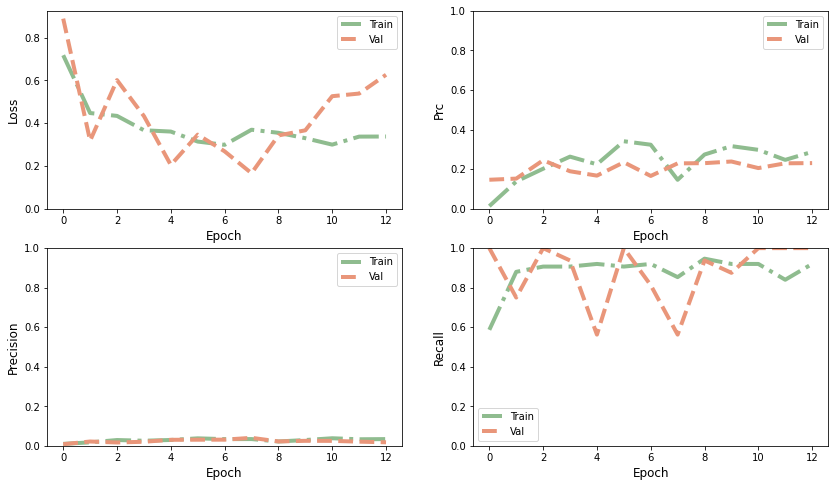

In [29]:
colors = random.sample(darker_colors, 2)
plt.figure(figsize=(14,8))
plot_metrics(baseline_history)

In [30]:
train_predictions_baseline = model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_baseline = model.predict(test_features, batch_size=BATCH_SIZE)

In [31]:
len(test_features[0])

7

In [32]:
train_df.head()

,merchant_category,transaction_volume_usd,otp_fraud,merchant_industry,transaction_week_start_date,centroid,pt2centroid
12497,0.0,1.000000,0.000000,0.000000,0.714286,0.871795,0.063072
15315,0.4,1.000000,0.387762,0.209677,1.000000,0.692308,0.362109
9531,0.9,0.058824,0.000000,0.661290,0.571429,0.025641,0.087961
1760,0.3,0.352941,0.000000,0.064516,0.000000,0.974359,0.116012
2877,0.3,0.588235,0.000000,0.064516,0.142857,0.974359,0.100287


In [33]:
def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(14,6))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('Legitimate Transactions Detected (True Negatives): ', cm[0][0])
  print('Legitimate Transactions Incorrectly Detected (False Positives): ', cm[0][1])
  print('Fraudulent Transactions Missed (False Negatives): ', cm[1][0])
  print('Fraudulent Transactions Detected (True Positives): ', cm[1][1])
  print('Total Fraudulent Transactions: ', np.sum(cm[1]))

loss :  0.6046344637870789
tp :  21.0
fp :  1164.0
tn :  2299.0
fn :  0.0
accuracy :  0.665901243686676
precision :  0.017721518874168396
recall :  1.0
auc :  0.9726565480232239
prc :  0.4499254822731018

Legitimate Transactions Detected (True Negatives):  2299
Legitimate Transactions Incorrectly Detected (False Positives):  1164
Fraudulent Transactions Missed (False Negatives):  0
Fraudulent Transactions Detected (True Positives):  21
Total Fraudulent Transactions:  21


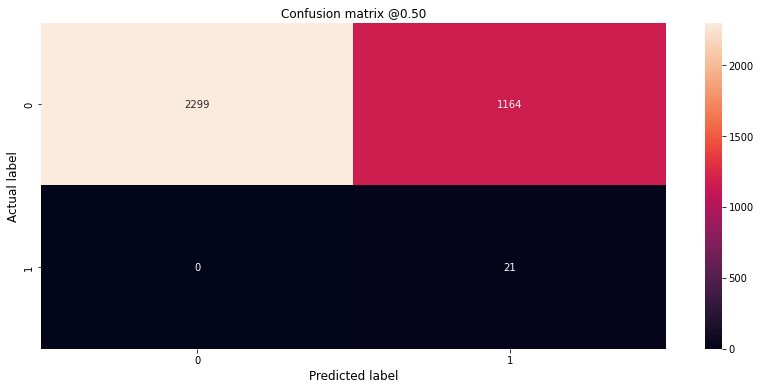

In [34]:
baseline_results = model.evaluate(test_features, test_labels,
                                  batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
  print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_baseline)

In this case, of the 21 fraudulent transactions, the model does remarkably well to detect all of them. This means it's very sensitive to detecting fraud, even though 1164 legitimate customers may be subject to more stringent anti-fraud measures since the model falsely identified their transactions as positive to fraud. But on the bright side, over 2200 out of 3463 legitimate customers enjoy a seamless, painless experience, with this model.

This is the **Precision** / **Recall** trade-off that most classification applications in real-life face. Often, to better optimise recall, precision takes a hit and vice-versa. We can always adjust this using hyper-parameters like batch-size and the specified neurons in our hidden layers.

In [35]:
# delete all stored model files after running notebook

if True:
    all_files = os.listdir()
    for f in all_files:
        if f.startswith('fraud_model_'):
            os.remove(f)
print('done!')

done!


In [36]:
# confirm deletion

os.listdir()

['Fraud_sample_data.xlsx',
 '.ipynb_checkpoints',
 '01_intro_to_fraud_analysis.ipynb',
 'fraud_analysis.ipynb',
 'july_df.csv',
 'data_dict.csv',
 'june_df.csv',
 'top_five_clusters.csv',
 'mi_combined.csv',
 'top_fraud_cluster.csv',
 'combined_df.csv',
 'processed_mi_combined.csv',
 '03_diagnostic_analytics.ipynb',
 'fraud_analyst_assignment_part2.gdoc',
 '02_descriptive_analytics.ipynb',
 'fraud_analyst_assignment_part1.gdoc',
 '04_predictive_analytics.ipynb',
 '05_prescriptive_analytics.ipynb']